In [1]:
# # Audio Sentiment Classification with AST
# 
# This notebook implements Audio Spectrogram Transformer (AST) for multi-class audio sentiment classification.
# Key features:
# - Data augmentation
# - Class imbalance handling
# - Performance optimization

## Setup and Imports

In [2]:
# Install required packages
!pip install --quiet transformers[torch] datasets accelerate>=0.26.0 librosa

In [3]:
# Standard library imports
import numpy as np
import librosa
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# Deep learning and ML frameworks
import transformers
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from datasets import Dataset
import sklearn.metrics as skm
from sklearn.model_selection import GroupShuffleSplit

# Utilities and visualization
import json
import matplotlib.pyplot as plt
from IPython.display import display

[HAMI-core Msg(129085:139657489415488:libvgpu.c:836)]: Initializing.....


## Data Loading and Preprocessing

First, we'll define functions to load and preprocess our audio data.

In [4]:
def load_data(data_path='../data/16k'):
    """
    Load and preprocess audio data and metadata.
    
    Args:
        data_path (str): Path to data directory
        
    Returns:
        tuple: (arrays, meta) containing audio data and metadata
    """
    arrays = np.load(f'{data_path}/training_25112024.npz')
    meta = json.load(open(f'{data_path}/meta.json', 'r'))
    
    print("Dataset statistics:")
    print(f"Number of samples: {len(arrays['X'])}")
    print("\nClass distribution:")
    for label, idx in meta['labels'].items():
        count = np.sum(arrays['y'] == idx)
        print(f"{label}: {count}")
        
    return arrays, meta

# Load the data
arrays, meta = load_data()

Dataset statistics:
Number of samples: 906

Class distribution:
Chanting/Singing: 370
Excitement: 96
Disappointment: 60
Celebration: 85
Boring: 295


## Audio Augmentation Functions

These functions implement various audio augmentation techniques to improve model robustness.

In [5]:
def pitch_shift(audio, sr=16000):
    """Apply random pitch shifting"""
    steps = np.random.uniform(-2, 2)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)

def time_stretch(audio):
    """Apply random time stretching"""
    rate = np.random.uniform(0.8, 1.2)
    return librosa.effects.time_stretch(audio, rate=rate)

def add_noise(audio, noise_level=0.005):
    """Add random Gaussian noise"""
    noise = np.random.normal(0, noise_level, len(audio))
    return audio + noise

def augment_audio(audio, sr=16000):
    """Apply random audio augmentation"""
    # Convert tensor to numpy if needed
    if torch.is_tensor(audio):
        audio = audio.numpy()
    
    # Choose augmentation type
    aug_type = np.random.choice(['pitch', 'noise'])
    
    if aug_type == 'pitch':
        steps = np.random.uniform(-2, 2)
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps)
    else:
        noise = np.random.normal(0, 0.005, len(audio))
        audio = audio + noise
        
    return torch.tensor(audio)

## Model Setup

Initialize the AST model and feature extractor.

In [6]:
def initialize_model(meta, model_name="MIT/ast-finetuned-audioset-10-10-0.4593"):
    """
    Initialize AST model and feature extractor.
    
    Args:
        meta (dict): Metadata with label information
        model_name (str): HuggingFace model identifier
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
    model = AutoModelForAudioClassification.from_pretrained(
        model_name,
        num_labels=len(meta['labels']),
        label2id=meta['labels'],
        id2label={v:k for k,v in meta['labels'].items()},
        ignore_mismatched_sizes=True
    ).to(device)
    
    return model, feature_extractor

# Initialize model
model, feature_extractor = initialize_model(meta)

[HAMI-core Warn(129085:139657489415488:utils.c:183)]: get default cuda from (null)
[HAMI-core Msg(129085:139657489415488:libvgpu.c:855)]: Initialized


Using device: cuda


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Dataset Preparation

Prepare the dataset with proper splitting and augmentation.

In [7]:
def prepare_dataset(arrays, feature_extractor, meta):
    """
    Prepare and split dataset with augmentation.
    
    Args:
        arrays (dict): Audio data arrays
        feature_extractor: AST feature extractor
        meta (dict): Metadata
    """
    preprocessed = feature_extractor(
        arrays['X'],
        sampling_rate=meta['sample_rate'],
        return_tensors="pt"
    )
    
    dataset = Dataset.from_dict({
        "input_values": preprocessed['input_values'],
        "label": arrays['y'],
    })
    
    # Split data
    gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
    train_idx, test_idx = next(gss.split(**arrays))
    
    return dataset, train_idx, test_idx

# Prepare dataset
dataset, train_idx, test_idx = prepare_dataset(arrays, feature_extractor, meta)

## Training Configuration

Set up training arguments and configuration.

In [8]:
def get_training_args():
    """Configure training arguments"""
    return transformers.TrainingArguments(
        'ast-finetuned-stadium-augmented',
        learning_rate=2e-5,
        warmup_ratio=0.2,
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=16,
        num_train_epochs=7,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        fp16=True,
        gradient_checkpointing=True,
        max_grad_norm=1.0,
        overwrite_output_dir=True  
    )

## Metrics Computation

Define functions for computing and visualizing model performance metrics.

In [9]:
def compute_metrics(pred):
    """
    Compute and visualize model metrics.
    
    Args:
        pred: Prediction object with labels and predictions
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    metrics = {
        'accuracy': skm.accuracy_score(labels, preds),
        'macro_f1': skm.f1_score(labels, preds, average='macro'),
        'weighted_f1': skm.f1_score(labels, preds, average='weighted')
    }
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    skm.ConfusionMatrixDisplay.from_predictions(
        labels, preds,
        display_labels=list(meta['labels'].keys()),
        ax=ax
    )
    plt.title("Confusion Matrix")
    display(fig)
    plt.close()
    
    print("\nClassification Report:")
    print(skm.classification_report(labels, preds))
    
    return metrics

## Model Training

Train the model with the configured parameters.

In [10]:
def train_model(model, dataset, train_idx, test_idx, training_args):
    """
    Train the AST model.
    
    Args:
        model: AST model
        dataset: Prepared dataset
        train_idx: Training indices
        test_idx: Testing indices
        training_args: Training configuration
    """
    train_ds = dataset.select(train_idx)
    eval_ds = dataset.select(test_idx)
    
    # Enable gradient checkpointing
    model.gradient_checkpointing_enable()
    
    # Free memory
    torch.cuda.empty_cache()
    
    trainer = transformers.Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        compute_metrics=compute_metrics
    )
    
    print("Starting training...")
    trainer.train()
    return trainer

## Execute Training

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,0.887668,0.628821,0.387052,0.578395
2,No log,0.633871,0.764192,0.651261,0.767524
3,No log,0.571863,0.816594,0.677357,0.812662
4,No log,0.576807,0.825328,0.676820,0.810879


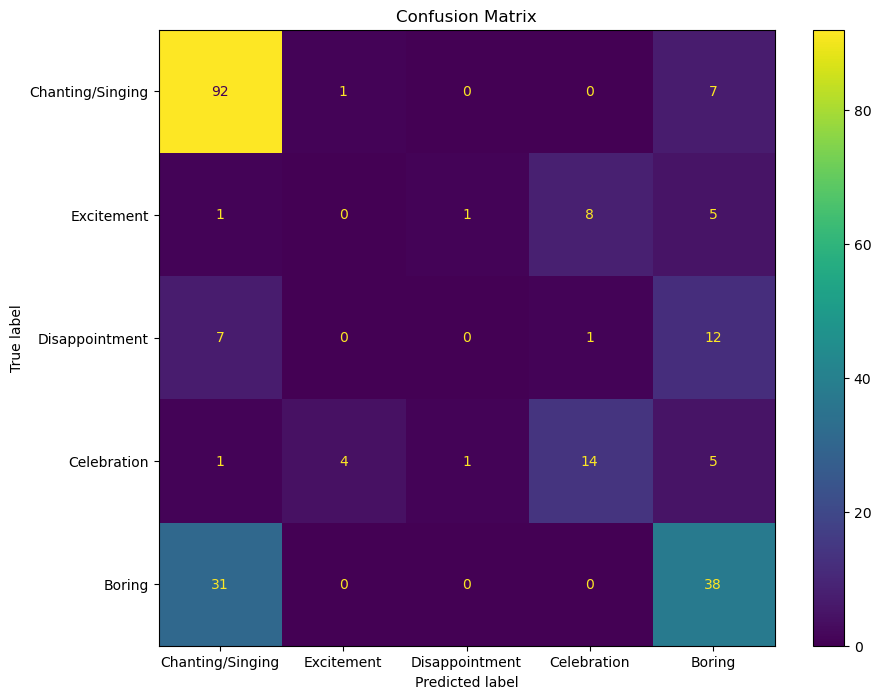


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.92      0.79       100
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        20
           3       0.61      0.56      0.58        25
           4       0.57      0.55      0.56        69

    accuracy                           0.63       229
   macro avg       0.37      0.41      0.39       229
weighted avg       0.54      0.63      0.58       229



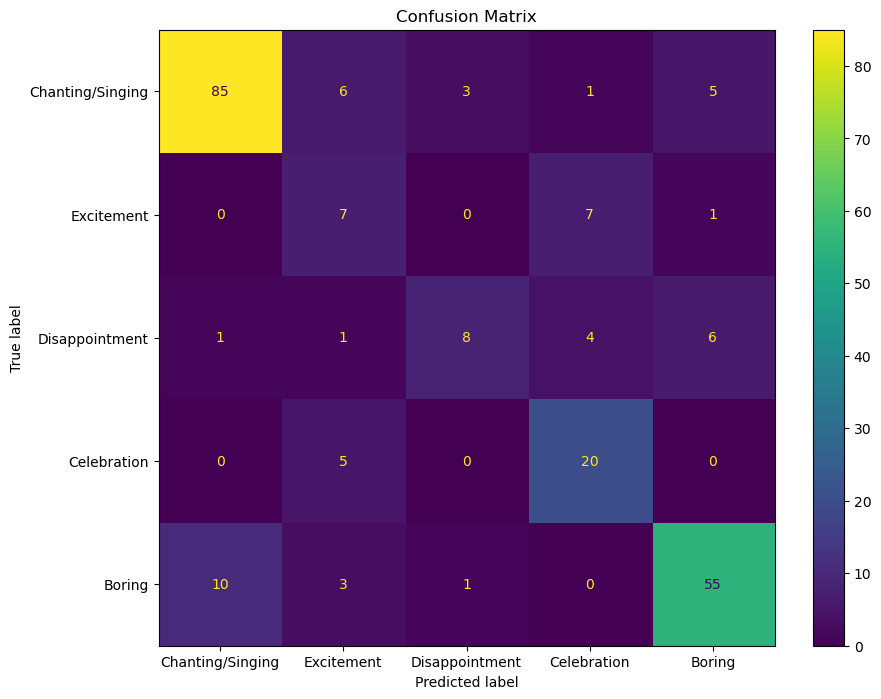


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       100
           1       0.32      0.47      0.38        15
           2       0.67      0.40      0.50        20
           3       0.62      0.80      0.70        25
           4       0.82      0.80      0.81        69

    accuracy                           0.76       229
   macro avg       0.66      0.66      0.65       229
weighted avg       0.78      0.76      0.77       229



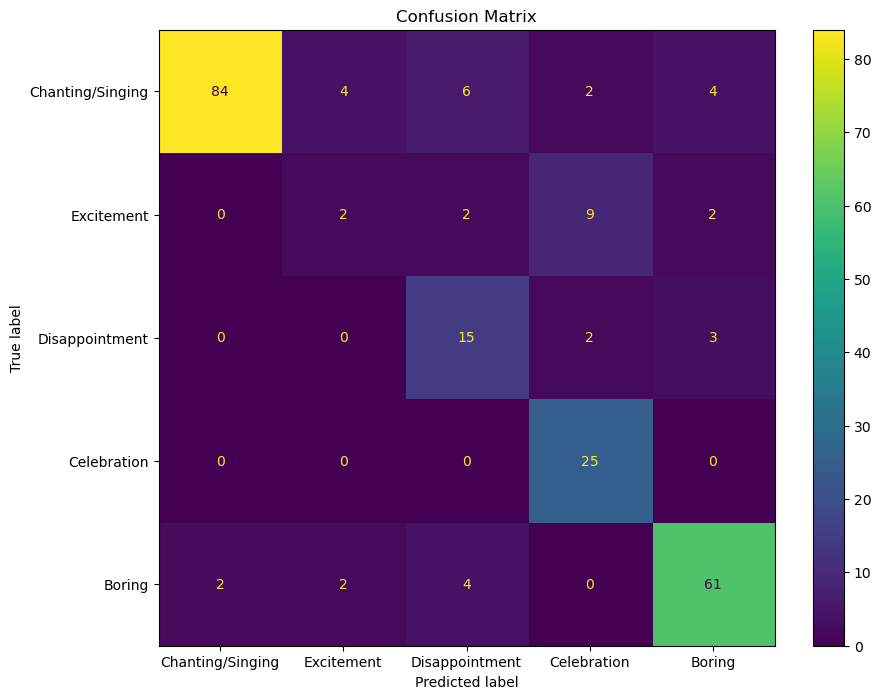


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       100
           1       0.25      0.13      0.17        15
           2       0.56      0.75      0.64        20
           3       0.66      1.00      0.79        25
           4       0.87      0.88      0.88        69

    accuracy                           0.82       229
   macro avg       0.66      0.72      0.68       229
weighted avg       0.83      0.82      0.81       229



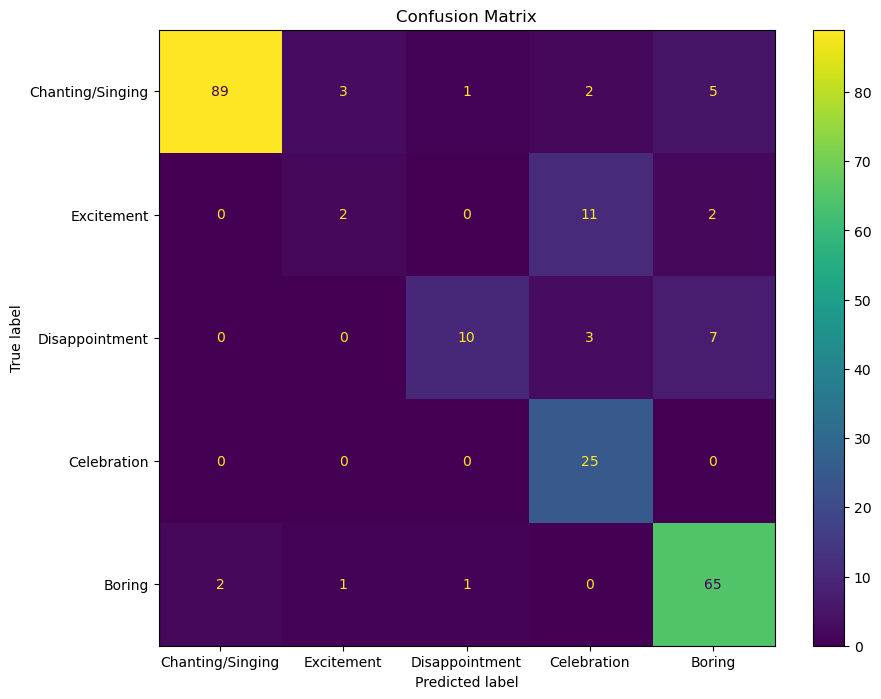


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       100
           1       0.33      0.13      0.19        15
           2       0.83      0.50      0.62        20
           3       0.61      1.00      0.76        25
           4       0.82      0.94      0.88        69

    accuracy                           0.83       229
   macro avg       0.72      0.69      0.68       229
weighted avg       0.84      0.83      0.82       229



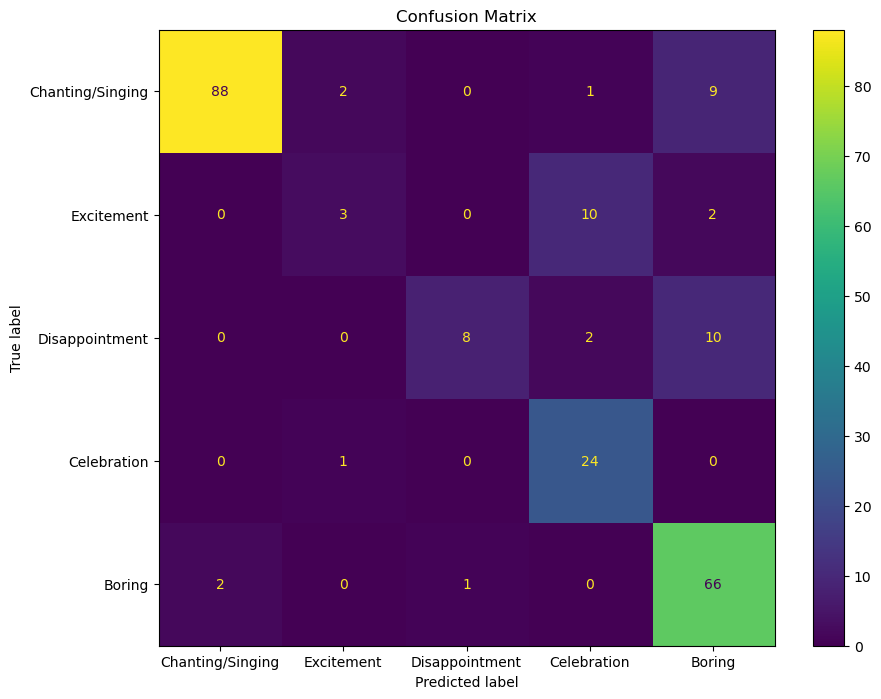


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       100
           1       0.50      0.20      0.29        15
           2       0.89      0.40      0.55        20
           3       0.65      0.96      0.77        25
           4       0.76      0.96      0.85        69

    accuracy                           0.83       229
   macro avg       0.75      0.68      0.68       229
weighted avg       0.84      0.83      0.81       229



In [11]:
# Set up training arguments
training_args = get_training_args()

# Train the model
trainer = train_model(model, dataset, train_idx, test_idx, training_args)

## Evaluation and Results


Final Evaluation Results:


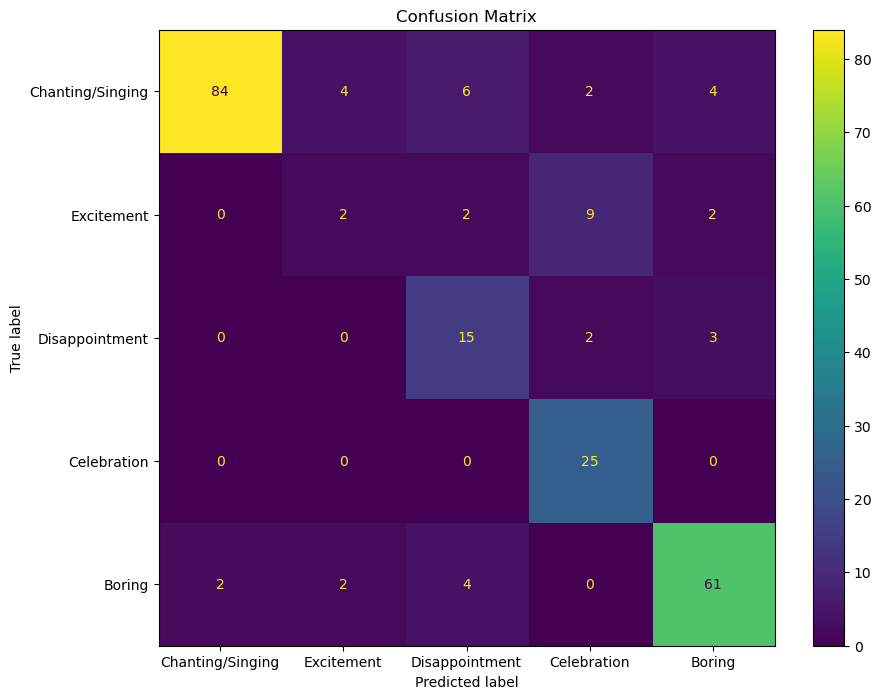


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       100
           1       0.25      0.13      0.17        15
           2       0.56      0.75      0.64        20
           3       0.66      1.00      0.79        25
           4       0.87      0.88      0.88        69

    accuracy                           0.82       229
   macro avg       0.66      0.72      0.68       229
weighted avg       0.83      0.82      0.81       229

{'eval_loss': 0.5718631744384766, 'eval_accuracy': 0.8165938864628821, 'eval_macro_f1': 0.6773570715295423, 'eval_weighted_f1': 0.8126622474434508, 'eval_runtime': 23.3857, 'eval_samples_per_second': 9.792, 'eval_steps_per_second': 4.918, 'epoch': 4.8023598820058995}


In [12]:
print("\nFinal Evaluation Results:")
final_results = trainer.evaluate()
print(final_results)

In [13]:
# Save the model
#trainer.save_model("./ast_model_final")
#print("\nModel saved to ./ast_model_final")